### Preprocess

In [ ]:
# make sure that rpy2 is installed: https://rpy2.bitbucket.io/
%load_ext rpy2.ipython

import warnings
from rpy2.rinterface import RRuntimeWarning

# ignore R warning messages
warnings.filterwarnings("ignore", category=RRuntimeWarning)

In [ ]:
%%R -o counts -o truecounts -o geneinfo -o cellinfo -o dropout

library(splatter)

dropout <- c()
simulate <- function(nGroups=6, nGenes=3000, batchCells=3000, dropout=1)
{
    if (nGroups > 1) method <- 'groups'
    else             method <- 'single'

    group.prob <- rep(1, nGroups) / nGroups
    
    # new splatter requires dropout.type
    sim <- splatSimulate(group.prob=group.prob, nGenes=nGenes, batchCells=batchCells,
                         dropout.type="experiment", method=method,
                         seed=42, dropout.shape=-1, dropout.mid=dropout, de.facScale=0.25)

    counts     <- as.data.frame(t(counts(sim)))
    truecounts <- as.data.frame(t(assays(sim)$TrueCounts))

    dropout    <- assays(sim)$Dropout
    mode(dropout) <- 'integer'
    dropout <- as.data.frame(dropout)
    
    cellinfo   <- as.data.frame(colData(sim))
    geneinfo   <- as.data.frame(rowData(sim))

    list(counts=counts,
         cellinfo=cellinfo,
         geneinfo=geneinfo,
         truecounts=truecounts,
         dropout=dropout)
}


sim <- simulate()

counts <- sim$counts
geneinfo <- sim$geneinfo
cellinfo <- sim$cellinfo
truecounts <- sim$truecounts

dropout <- c(dropout, (sum(counts==0)-sum(truecounts==0))/sum(truecounts>0))

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.sparse as sp
import matplotlib.pyplot as plt

In [ ]:
adata = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
adata.obs_names = cellinfo.Cell
adata.var_names = geneinfo.Gene
sc.pp.filter_genes(adata, min_counts=1)
adata.write('./splatter_data/counts_simulated_dataset3_3000x3000_dropout{:.2f}.h5ad'.format(dropout[0]))

In [ ]:
adata_true = sc.AnnData(truecounts.values, obs=cellinfo, var=geneinfo)
adata_true.obs_names = cellinfo.Cell
adata_true.var_names = geneinfo.Gene
adata_true = adata_true[:, adata.var_names].copy()
adata_true.write('./splatter_data/truecounts_simulated_dataset3_3000x3000_dropout{:.2f}.h5ad'.format(dropout[0]))

#### Construction of gene-to-gene relationships. (It might take hours to calculate if the dataset is large, we recommend computing the PCC in parallel by using C++)

In [ ]:
Genes = adata.var_names.values
Cells = adata.obs_names.values
express = pd.DataFrame(adata.X, columns=Genes, index=Cells)

In [ ]:
corr = express.corr()

row, col = [], []
for i in range(len(Genes)):
    for j in range(len(Genes)):
        if np.abs(cor.iloc[i,j]) > 0.3 and i != j:
            row.append(i)
            col.append(j)
            
adj = sp.csc_matrix((np.ones(len(row)), (row, col)), shape=(len(Genes), len(Genes)))

In [ ]:
sp.save_npz('./splatter_data/counts_simulated_dataset3_3000x3000_dropout0.30.npz', adj)

### Training

In [ ]:
!python train.py --adata ./splatter_data/counts_simulated_dataset3_3000x3000_dropout0.30.h5ad --adj  --learning_rate 1e-3 --epochs 100 --hidden1 32 --hidden2 64 --batch_size 50 --dropout 0.1

### Evaluation

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
adata = sc.read('./graphsci_simulated_dataset.h5ad')

In [2]:
from sklearn.preprocessing import LabelEncoder
X, y = np.array(adata.X), np.array(adata.obs.Group)
lf=LabelEncoder().fit(y)
y_true=lf.transform(y)

In [3]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt 

X = np.array(adata.X)
tsne=TSNE()
tsne.fit_transform(X)

tsne=pd.DataFrame(tsne.embedding_)

([], [])

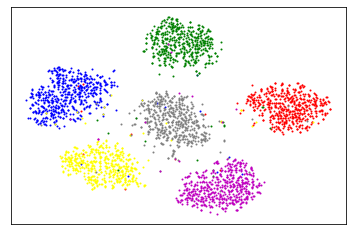

In [4]:
pca = tsne
d=pca[y_true==0]
plt.scatter(d[0],d[1],c='r',s=1)

d=pca[y_true==1]
plt.scatter(d[0],d[1],c='b',s=1)

d=pca[y_true==2]
plt.scatter(d[0],d[1],c='yellow',s=1)

d=pca[y_true==3]
plt.scatter(d[0],d[1],c='grey',s=1)

d=pca[y_true==4]
plt.scatter(d[0],d[1],c='g',s=1)

d=pca[y_true==5]
plt.scatter(d[0],d[1],c='m',s=1)

plt.xticks([])
plt.yticks([])

Trying to set attribute `.uns` of view, copying.


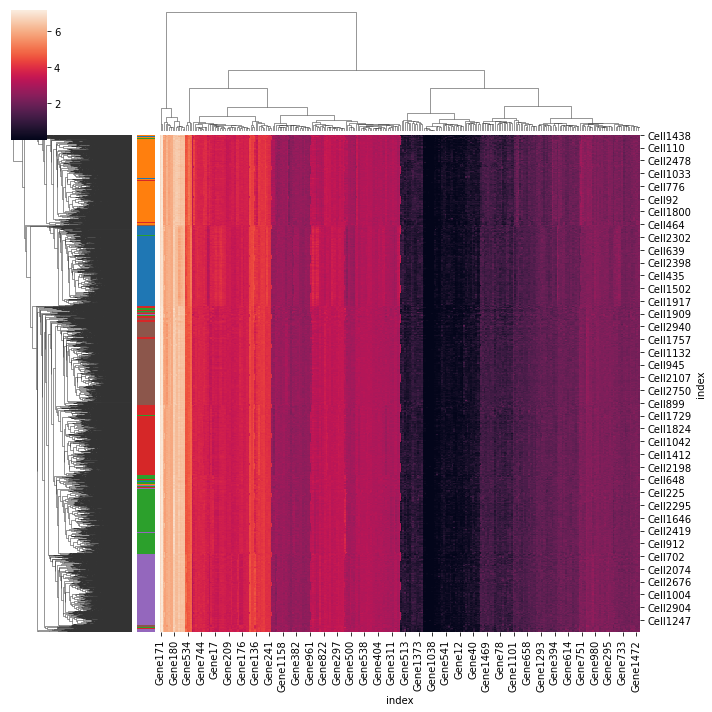

In [7]:
de_genes = (adata.var.loc[:, 'DEFacGroup1':'DEFacGroup2'].values.sum(1) != 2.0)

sc.pl.clustermap(adata[:, de_genes], 'Group', use_raw=False)